In [1]:
from utils.draw import draw_custom_weighted_graph
from ga.tsp_ga import TSPGA
from ga.tsp_ga_din_crossover import TSPGA as TSPGAC
from ga.tsp_ga_parallel import TSPGA as TSPGAP

In [2]:
from itertools import permutations
import random
from tqdm import tqdm
def generate_network(num_nodes, rand_a, rand_b):
    nodes_list = [x for x in range(num_nodes)]
    edges = list(permutations(nodes_list, 2))
    edges_w = [(*x, random.randint(rand_a,rand_b)) for x in edges]

    return nodes_list, edges_w

def evaluate_several_options(gas = [], steps_number = 100):
    steps = []
    costs_list = [[] for _ in gas]
    for step in tqdm(range(steps_number), desc="Running RA for all options"):
        for idx, ga in enumerate(gas):
            new_population, new_costs = ga.step()
            tour,cost = min(zip(new_population, new_costs), key=lambda el:el[1])
            costs_list[idx].append(cost)
        steps.append(step)
    return steps, costs_list

In [3]:
def generate_one_side_grid(params, attribute, values ):
    params_list = []
    labels = []
    for value in values:
        param = params.copy()
        param[attribute] = value
        params_list.append(param)
        labels.append(f"{attribute}:{value}")
    return params_list, labels

In [4]:
import numpy as np
from functools import reduce

def calculate_percentile(value, values):
    # Convert the input values to a numpy array
    values = np.array(values)
    
    # Calculate the percentile rank of the given value
    percentile_rank = (np.sum(values < value) / len(values) * 100)//1
    
    return percentile_rank
    
def calculate_percentiles(costs, comparing_step = 100):
    # Get the final cost for each scenario (the last element in each list)
    flat_costs = reduce(lambda a,b : a+b, costs)
    
    
    # Calculate the percentile rank of the given value
    percentile_rank = [calculate_percentile(cost[comparing_step], flat_costs) for cost in costs]
    
    return percentile_rank


In [5]:
import multiprocessing as mp


def evaluate_several_options_single(ga, steps_number=100):
    steps = []
    costs_list = []
    for step in tqdm(range(steps_number), desc=f"Running GA for single option", leave=False):
        new_population, new_costs = ga.step()
        tour, cost = min(zip(new_population, new_costs), key=lambda el: el[1])
        costs_list.append(cost)
        steps.append(step)
    return steps, costs_list

def evaluate_several_options_parallel(gas, steps_number=100):
    # Create a pool of workers
    with mp.Pool(mp.cpu_count()) as pool:
        # Parallelize the evaluation of all GA instances
        results = pool.starmap(evaluate_several_options_single, [(ga, steps_number) for ga in gas])

    # Unpack the results
    steps = [result[0] for result in results]  # List of step sequences for each GA
    costs_list = [result[1] for result in results]  # List of cost sequences for each GA
    return steps, costs_list

# Finding best crossover based on population

In [6]:
%%time

results = {}
cost_dict = {}

values_to_iterate = [round(x/10,1) for x in range(1,11,1)]
for NUM_NODES in [20,40,60,80]:
    print(NUM_NODES)

    nodes_list, edges_w = generate_network(num_nodes=NUM_NODES,rand_a=0,rand_b=200)
    
    params = {
    "population_prop":1.1, "crossover_proportion":0.8,"mutation_thd":0.3, "exploration_prob":0.2
    }
    params_list, labels = generate_one_side_grid(params, "exploration_prob", values = values_to_iterate)
    
    gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]
    
    steps, costs = evaluate_several_options_parallel(gas=gas, steps_number=100)
    results[f"testing {NUM_NODES} nodes"] = calculate_percentiles(costs, comparing_step=50)
    cost_dict[f"testing {NUM_NODES} nodes"] = costs

20


40


60


80


CPU times: user 644 ms, sys: 564 ms, total: 1.21 s
Wall time: 25.7 s


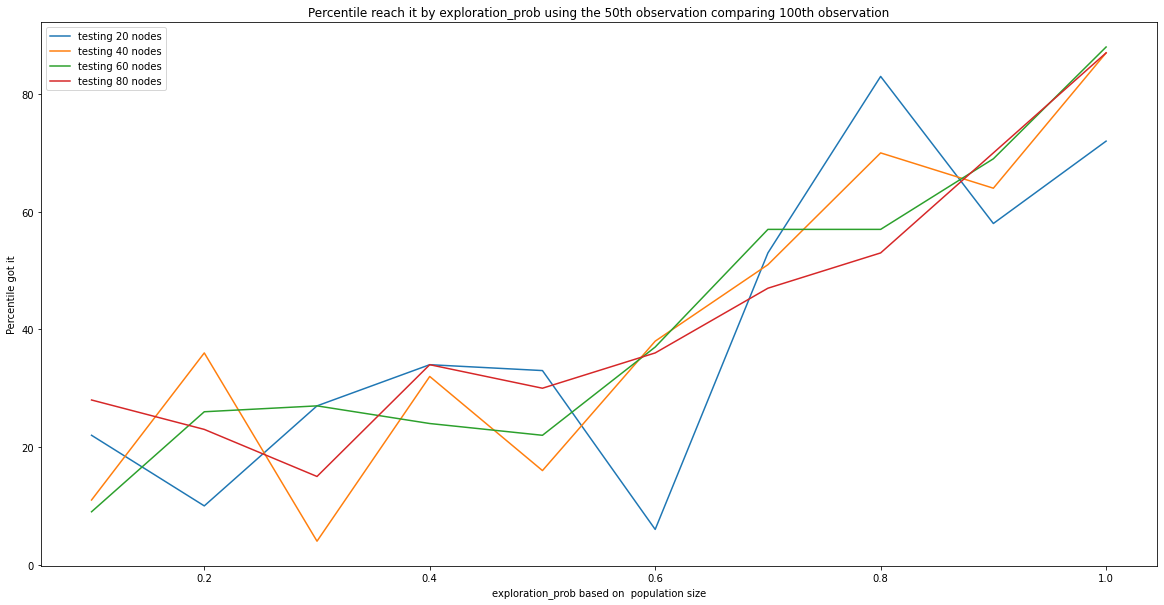

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 10))
for idx, values in results.items():
    sns.lineplot(x =values_to_iterate, y =values, label=idx)
plt.title("Percentile reach it by exploration_prob using the 50th observation comparing 100th observation")
plt.xlabel("exploration_prob based on  population size")
plt.ylabel("Percentile got it")
plt.show()

In [8]:
import pandas as pd
df = pd.DataFrame(data=results.values(), columns=labels)
df.index = results.keys()
avg_list = [df[fld].mean() for fld in df.columns]
df = df.T
df["AVG"] = avg_list
df

,testing 20 nodes,testing 40 nodes,testing 60 nodes,testing 80 nodes,AVG
exploration_prob:0.1,22.0,11.0,9.0,28.0,17.50
exploration_prob:0.2,10.0,36.0,26.0,23.0,23.75
exploration_prob:0.3,27.0,4.0,27.0,15.0,18.25
exploration_prob:0.4,34.0,32.0,24.0,34.0,31.00
exploration_prob:0.5,33.0,16.0,22.0,30.0,25.25
exploration_prob:0.6,6.0,38.0,37.0,36.0,29.25
exploration_prob:0.7,53.0,51.0,57.0,47.0,52.00
exploration_prob:0.8,83.0,70.0,57.0,53.0,65.75
exploration_prob:0.9,58.0,64.0,69.0,70.0,65.25
exploration_prob:1.0,72.0,87.0,88.0,87.0,83.50


In [9]:
df.to_csv("data/exploration_prob_1.csv")

In [10]:
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  testing 20 nodes &  testing 40 nodes &  testing 60 nodes &  testing 80 nodes &    AVG \\
\midrule
exploration\_prob:0.1 &              22.0 &              11.0 &               9.0 &              28.0 &  17.50 \\
exploration\_prob:0.2 &              10.0 &              36.0 &              26.0 &              23.0 &  23.75 \\
exploration\_prob:0.3 &              27.0 &               4.0 &              27.0 &              15.0 &  18.25 \\
exploration\_prob:0.4 &              34.0 &              32.0 &              24.0 &              34.0 &  31.00 \\
exploration\_prob:0.5 &              33.0 &              16.0 &              22.0 &              30.0 &  25.25 \\
exploration\_prob:0.6 &               6.0 &              38.0 &              37.0 &              36.0 &  29.25 \\
exploration\_prob:0.7 &              53.0 &              51.0 &              57.0 &              47.0 &  52.00 \\
exploration\_prob:0.8 &              83.0 &              70.0 &  

/tmp/ipykernel_74907/2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


In [11]:
%%time

results = {}
cost_dict = {}

values_to_iterate = [round(x/1000,2) for x in range(0,200,20)]
for NUM_NODES in [20,40,60,80]:
    print(NUM_NODES)

    nodes_list, edges_w = generate_network(num_nodes=NUM_NODES,rand_a=0,rand_b=200)
    
    params = {
    "population_prop":1.1, "crossover_proportion":0.8,"mutation_thd":0.3, "exploration_prob":0.2
    }
    params_list, labels = generate_one_side_grid(params, "exploration_prob", values = values_to_iterate)
    
    gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]
    
    steps, costs = evaluate_several_options_parallel(gas=gas, steps_number=100)
    results[f"testing {NUM_NODES} nodes"] = calculate_percentiles(costs, comparing_step=50)
    cost_dict[f"testing {NUM_NODES} nodes"] = costs

20


40


60


80


CPU times: user 646 ms, sys: 655 ms, total: 1.3 s
Wall time: 22.6 s


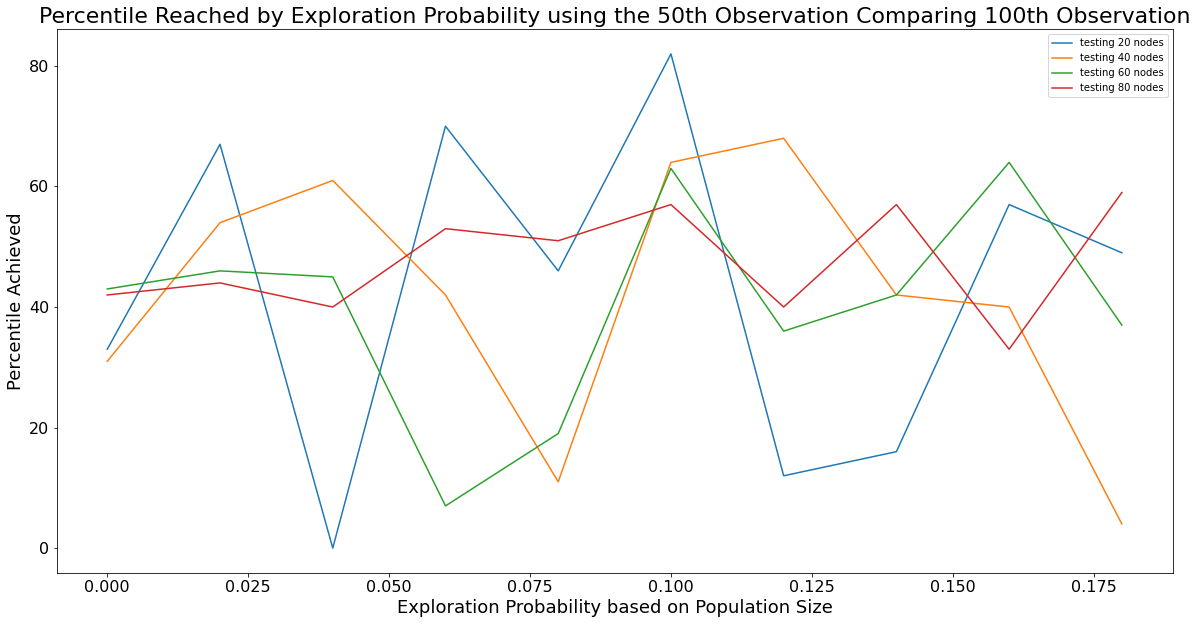

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))

# Plotting data
for idx, values in results.items():
    sns.lineplot(x=values_to_iterate, y=values, label=idx)

# Adding titles and labels with larger font sizes
plt.title("Percentile Reached by Exploration Probability using the 50th Observation Comparing 100th Observation", fontsize=22)
plt.xlabel("Exploration Probability based on Population Size", fontsize=18)
plt.ylabel("Percentile Achieved", fontsize=18)

# Increasing the font size of the ticks on both axes
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the plot as a PNG file
plt.savefig('imgs/exploration_prob_vs_percentile.png', format='png', dpi=300)

# Display the plot
plt.show()


In [13]:
import pandas as pd
df = pd.DataFrame(data=results.values(), columns=labels)
df.index = results.keys()
avg_list = [df[fld].mean() for fld in df.columns]
df = df.T
df["AVG"] = avg_list
df

,testing 20 nodes,testing 40 nodes,testing 60 nodes,testing 80 nodes,AVG
exploration_prob:0.0,33.0,31.0,43.0,42.0,37.25
exploration_prob:0.02,67.0,54.0,46.0,44.0,52.75
exploration_prob:0.04,0.0,61.0,45.0,40.0,36.50
exploration_prob:0.06,70.0,42.0,7.0,53.0,43.00
exploration_prob:0.08,46.0,11.0,19.0,51.0,31.75
exploration_prob:0.1,82.0,64.0,63.0,57.0,66.50
exploration_prob:0.12,12.0,68.0,36.0,40.0,39.00
exploration_prob:0.14,16.0,42.0,42.0,57.0,39.25
exploration_prob:0.16,57.0,40.0,64.0,33.0,48.50
exploration_prob:0.18,49.0,4.0,37.0,59.0,37.25


In [17]:
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  testing 20 nodes &  testing 40 nodes &  testing 60 nodes &  testing 80 nodes &    AVG \\
\midrule
exploration\_prob:0.0  &              33.0 &              31.0 &              43.0 &              42.0 &  37.25 \\
exploration\_prob:0.02 &              67.0 &              54.0 &              46.0 &              44.0 &  52.75 \\
exploration\_prob:0.04 &               0.0 &              61.0 &              45.0 &              40.0 &  36.50 \\
exploration\_prob:0.06 &              70.0 &              42.0 &               7.0 &              53.0 &  43.00 \\
exploration\_prob:0.08 &              46.0 &              11.0 &              19.0 &              51.0 &  31.75 \\
exploration\_prob:0.1  &              82.0 &              64.0 &              63.0 &              57.0 &  66.50 \\
exploration\_prob:0.12 &              12.0 &              68.0 &              36.0 &              40.0 &  39.00 \\
exploration\_prob:0.14 &              16.0 &              

/tmp/ipykernel_74907/2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


In [14]:
df.to_csv("data/exploration_prob_2.csv")

# Justify

It looks to this specific problem there is no any advatage to use this param different to 0. However we can discuss this further

### Conclution
0.2 param will be used